In [2]:
import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import export_graphviz
# import pydotplus
from IPython.display import Image


In [3]:
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)
sample = pd.read_csv('submit_sample.csv', header=None)

In [4]:
train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
0,31,services,married,secondary,no,12294,yes,no,cellular,21,nov,101,3,498,0,other,0
1,29,entrepreneur,single,tertiary,no,43027,no,no,cellular,22,aug,158,2,702,0,unknown,1
2,35,management,married,tertiary,no,12252,yes,no,cellular,11,nov,351,1,826,0,failure,0
3,31,technician,married,secondary,no,99121,yes,yes,unknown,16,may,658,2,120,0,failure,0
4,48,unemployed,married,primary,no,42005,yes,no,telephone,3,apr,177,1,273,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27095,37,blue-collar,married,secondary,no,26661,yes,no,cellular,27,may,345,4,425,0,unknown,0
27096,35,services,married,secondary,no,42150,yes,no,cellular,27,may,121,1,719,0,unknown,0
27097,35,services,married,unknown,no,34531,no,no,cellular,28,jun,177,2,121,0,unknown,0


In [5]:
cols_o = train.select_dtypes(include=object).columns.tolist()
cols_o

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [6]:
cols_i = train.select_dtypes(exclude=object).columns.tolist()
cols_i

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'y']

In [7]:
test['y'] = -999

In [8]:
all_df = pd.concat([train, test], axis=0)
all_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
0,31,services,married,secondary,no,12294,yes,no,cellular,21,nov,101,3,498,0,other,0
1,29,entrepreneur,single,tertiary,no,43027,no,no,cellular,22,aug,158,2,702,0,unknown,1
2,35,management,married,tertiary,no,12252,yes,no,cellular,11,nov,351,1,826,0,failure,0
3,31,technician,married,secondary,no,99121,yes,yes,unknown,16,may,658,2,120,0,failure,0
4,48,unemployed,married,primary,no,42005,yes,no,telephone,3,apr,177,1,273,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18045,49,self-employed,married,tertiary,no,98357,yes,no,cellular,6,jul,101,2,417,0,failure,-999
18046,34,blue-collar,married,secondary,no,29621,yes,no,cellular,12,may,345,1,815,0,unknown,-999
18047,34,admin.,single,secondary,no,94260,yes,no,unknown,16,may,121,2,370,0,unknown,-999


In [9]:
le = LabelEncoder()

for col in all_df.columns.drop('y'):
    all_df[col] = le.fit_transform(all_df[col])

all_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
0,9,7,1,1,0,6616,1,0,0,20,8,35,2,499,0,1,0
1,7,2,2,2,0,17047,0,0,0,21,1,66,1,703,0,3,1
2,13,4,1,2,0,6602,1,0,0,10,8,103,0,827,0,0,0
3,9,9,1,1,0,35951,1,1,2,15,7,124,1,121,0,0,0
4,26,10,1,0,0,16689,1,0,1,2,0,71,0,274,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18045,27,6,1,2,0,35680,1,0,0,5,4,35,1,418,0,0,-999
18046,12,1,1,1,0,12474,1,0,0,11,7,101,0,816,0,3,-999
18047,12,0,2,1,0,34245,1,0,2,15,7,42,1,371,0,3,-999


In [10]:
std = StandardScaler()
all_df_std = std.fit_transform(all_df.drop('y', axis=1))
all_df_std

array([[-0.65111009,  0.82964952, -0.30302637, ...,  0.25429016,
        -0.23730182, -1.71840175],
       [-0.9075186 , -0.6915644 ,  1.45599146, ...,  1.06430014,
        -0.23730182,  0.39816254],
       [-0.13829306, -0.08307883, -0.30302637, ...,  1.55665915,
        -0.23730182, -2.7766839 ],
       ...,
       [-0.26649732, -1.30004997,  1.45599146, ..., -0.2539514 ,
        -0.23730182,  0.39816254],
       [-0.65111009,  1.43813509,  1.45599146, ..., -1.56029103,
        -0.23730182,  0.39816254],
       [-0.77931434,  0.22116395, -0.30302637, ...,  1.05238823,
        -0.23730182,  0.39816254]])

In [11]:
all_df_std[:27100]

array([[-0.65111009,  0.82964952, -0.30302637, ...,  0.25429016,
        -0.23730182, -1.71840175],
       [-0.9075186 , -0.6915644 ,  1.45599146, ...,  1.06430014,
        -0.23730182,  0.39816254],
       [-0.13829306, -0.08307883, -0.30302637, ...,  1.55665915,
        -0.23730182, -2.7766839 ],
       ...,
       [-0.13829306,  0.82964952, -0.30302637, ..., -1.24264006,
        -0.23730182,  0.39816254],
       [-0.77931434, -1.30004997,  1.45599146, ..., -1.32602344,
        -0.23730182,  0.39816254],
       [-0.26649732, -0.08307883, -0.30302637, ..., -0.44851262,
        -0.23730182,  0.39816254]])

In [12]:
all_df['y']

id
0          0
1          1
2          0
3          0
4          0
        ... 
18045   -999
18046   -999
18047   -999
18048   -999
18049   -999
Name: y, Length: 45150, dtype: int64

In [13]:
X, X_test, y, y_test = train_test_split(all_df_std[:27100], all_df['y'][:27100], test_size=0.3, random_state=0)

In [14]:
# X = all_df_std[:27100]
# y = all_df['y'][:27100]
X.shape, y.shape

((18970, 16), (18970,))

In [15]:
X

array([[-0.52290583, -1.30004997, -0.30302637, ...,  0.60767687,
        -0.23730182,  0.39816254],
       [ 1.400158  ,  0.82964952, -0.30302637, ...,  1.19533117,
        -0.23730182,  0.39816254],
       [ 2.16938353,  1.74237788,  1.45599146, ...,  1.49312896,
        -0.23730182,  0.39816254],
       ...,
       [ 3.06681332, -0.6915644 ,  1.45599146, ..., -0.45248326,
        -0.23730182,  0.39816254],
       [-0.52290583, -0.6915644 , -0.30302637, ..., -1.58411485,
        -0.23730182,  0.39816254],
       [-0.77931434, -0.99580719,  1.45599146, ..., -1.00440183,
        -0.23730182,  0.39816254]])

In [16]:
y

id
16404    0
2185     0
10080    1
4211     0
22914    0
        ..
13123    0
19648    0
9845     0
10799    0
2732     0
Name: y, Length: 18970, dtype: int64

## LightGBM

In [17]:
parameters = {
    'max_depth': list(range(1, 20)),
    'learning_rate': [1, 0.5, 0.1, 0.05, 0.01],
}

In [18]:
lgb = LGBMClassifier()

gcv = GridSearchCV(lgb, parameters, cv=5, scoring="roc_auc", n_jobs=-1, return_train_score=True)
gcv.fit(X, y)


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [1, 0.5, 0.1, 0.05, 0.01],
                         'm

In [19]:
gcv.best_params_

{'learning_rate': 0.1, 'max_depth': 4}

In [20]:
gcv.cv_results_

{'mean_fit_time': array([0.42411313, 0.50608578, 0.55331864, 0.64766722, 0.74480696,
        0.81472459, 0.90763016, 0.82839651, 0.79981132, 0.82793198,
        0.86542249, 1.02263036, 0.84092984, 0.83055034, 0.80817475,
        0.81230898, 0.81543465, 0.8185585 , 0.85292373, 0.46551566,
        0.47801361, 0.51238089, 0.59361095, 0.69768815, 0.76856909,
        0.74531045, 0.77170072, 0.74896493, 0.74357648, 0.74669991,
        0.74982371, 0.73732719, 0.74669909, 0.78106523, 0.8404295 ,
        0.74045067, 0.74859724, 0.74045234, 0.40303097, 0.45614386,
        0.51550522, 0.62485433, 0.73887162, 0.9247838 , 0.89354105,
        0.80068808, 0.8248601 , 0.81230884, 0.80606089, 0.81543503,
        0.81856027, 0.80918593, 0.8185586 , 0.81544275, 0.83105583,
        0.81370735, 0.82480807, 0.40303082, 0.45301814, 0.53737531,
        0.62485433, 0.77351866, 0.87765212, 0.89700022, 0.9519928 ,
        0.88548775, 0.88729277, 0.8872932 , 0.89978857, 0.88729129,
        0.88729277, 0.89090362,

In [21]:
# train_score = gcv.cv_results_['mean_train_score']
# test_score = gcv.cv_results_['mean_test_score']


In [22]:
# plt.plot(train_score)
# plt.plot(test_score)
# plt.xticks(range(0, len(gcv.param_grid['max_depth'])), list(gcv.param_grid['max_depth']))

In [23]:
gcv.predict(X)[70:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [24]:
gcv.predict_proba(X)[70:100]

array([[0.89344246, 0.10655754],
       [0.97969756, 0.02030244],
       [0.99471877, 0.00528123],
       [0.99550196, 0.00449804],
       [0.97215681, 0.02784319],
       [0.88387008, 0.11612992],
       [0.77228058, 0.22771942],
       [0.93958328, 0.06041672],
       [0.75661881, 0.24338119],
       [0.99439737, 0.00560263],
       [0.93377208, 0.06622792],
       [0.97260216, 0.02739784],
       [0.99591227, 0.00408773],
       [0.23102036, 0.76897964],
       [0.88250665, 0.11749335],
       [0.97642934, 0.02357066],
       [0.81397962, 0.18602038],
       [0.83411662, 0.16588338],
       [0.8743471 , 0.1256529 ],
       [0.97503264, 0.02496736],
       [0.98111217, 0.01888783],
       [0.99521279, 0.00478721],
       [0.97504959, 0.02495041],
       [0.96063719, 0.03936281],
       [0.99241644, 0.00758356],
       [0.99491014, 0.00508986],
       [0.98579298, 0.01420702],
       [0.97248138, 0.02751862],
       [0.9049756 , 0.0950244 ],
       [0.87886866, 0.12113134]])

In [25]:
pred_list = {}
pred_list['lgb'] = gcv.predict_proba(X)[:,1]


In [26]:
y_pred = gcv.predict_proba(X_test)[:,1]
y_pred

array([0.07973818, 0.01165357, 0.05432051, ..., 0.02536566, 0.05083446,
       0.32856249])

In [27]:
roc_auc_score(y_test, y_pred)
# 0.8456841121038058

0.8471041391307783

In [28]:
pred_list_test = {}
pred_list_test['lgb'] = y_pred

## XGBoost

In [29]:
parameters = {
    "learning_rate":[0.1,0.3,0.5],
    "max_depth": [2,3,5,10],
     "subsample":[0.5,0.8,0.9,1],
     "colsample_bytree": [0.5,1.0],    
}

In [30]:
xgb = XGBClassifier()

gcv2 = GridSearchCV(xgb, parameters, cv=5, scoring="roc_auc", n_jobs=-1, return_train_score=True)
gcv2.fit(X, y)


C:\Users\yanai\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:54:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     use_label_encoder=True,
                                     validate_parameters=None, verbosity=N

In [31]:
gcv2.best_params_

{'colsample_bytree': 0.5, 'learning_rate': 0.3, 'max_depth': 3, 'subsample': 1}

([<matplotlib.axis.XTick at 0x184fd4cc308>,
 <a list of 4 Text xticklabel objects>)

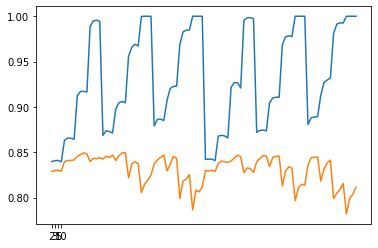

In [32]:
train_score = gcv2.cv_results_['mean_train_score']
test_score = gcv2.cv_results_['mean_test_score']

plt.plot(train_score)
plt.plot(test_score)
plt.xticks(range(0, len(gcv2.param_grid['max_depth'])), list(gcv2.param_grid['max_depth']))

In [33]:
pred_list['xgb'] = gcv2.predict_proba(X)[:,1]

In [34]:
y_pred2 = gcv2.predict_proba(X_test)[:,1]
y_pred2

array([0.05985259, 0.00354495, 0.04834737, ..., 0.01401991, 0.04714927,
       0.32444254], dtype=float32)

In [35]:
roc_auc_score(y_test, y_pred2)
# 0.8465594251123711

0.8514759909497124

In [36]:
pred_list_test['xgb'] = y_pred2

## LogisticRegression

In [37]:
gcv3 = LogisticRegression()

gcv3.fit(X, y)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [38]:
pred_list['logistic'] = gcv3.predict_proba(X)[:,1]
pred_list

{'lgb': array([0.00470889, 0.02198604, 0.31679198, ..., 0.08396603, 0.03355767,
        0.03315842]),
 'xgb': array([0.00356331, 0.0109377 , 0.34164712, ..., 0.09050049, 0.02929658,
        0.02884594], dtype=float32),
 'logistic': array([0.03765994, 0.03348983, 0.27168502, ..., 0.17384506, 0.01905472,
        0.04958183])}

In [39]:
y_pred3 = gcv3.predict_proba(X_test)[:,1]
y_pred3

array([0.07579774, 0.031406  , 0.03865054, ..., 0.02315975, 0.02580815,
       0.04051947])

In [40]:
roc_auc_score(y_test, y_pred3)
# 0.7605951589804085

0.7605951589804085

In [41]:
pred_list_test['logistic'] = y_pred3

## Random Forest

In [42]:
parameters = {
    'max_depth': list(range(1, 20)),
    'max_features': [1, 2, 3, 4, 5, 7, 10],
}

In [43]:
rf = RandomForestClassifier()

gcv4 = GridSearchCV(rf, parameters, cv=5, scoring="roc_auc", n_jobs=-1, return_train_score=True)
gcv4.fit(X, y)


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [44]:
gcv4.best_params_

{'max_depth': 15, 'max_features': 3}

([<matplotlib.axis.XTick at 0x184fd787808>,
 <a list of 19 Text xticklabel objects>)

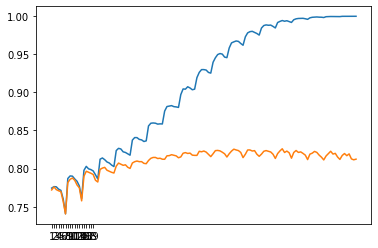

In [45]:
train_score = gcv4.cv_results_['mean_train_score']
test_score = gcv4.cv_results_['mean_test_score']

plt.plot(train_score)
plt.plot(test_score)
plt.xticks(range(0, len(gcv4.param_grid['max_depth'])), list(gcv4.param_grid['max_depth']))

In [46]:
pred_list['rf'] = gcv4.predict_proba(X)[:,1]

In [47]:
y_pred4 = gcv4.predict_proba(X_test)[:,1]
y_pred4

array([0.06614025, 0.00461935, 0.13043334, ..., 0.0282606 , 0.07575528,
       0.19278017])

In [48]:
roc_auc_score(y_test, y_pred4)
# 0.8195972033973815

0.8252765259679561

In [49]:
pred_list_test['rf'] = y_pred4

## Desicion Tree

In [50]:
parameters = {
    'max_depth': list(range(1, 20)),
}

In [51]:
dt = DecisionTreeClassifier()

gcv5 = GridSearchCV(dt, parameters, cv=5, scoring="roc_auc", n_jobs=-1, return_train_score=True)
gcv5.fit(X, y)


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
  

In [52]:
gcv5.best_params_

{'max_depth': 6}

([<matplotlib.axis.XTick at 0x184fd514908>,
 <a list of 19 Text xticklabel objects>)

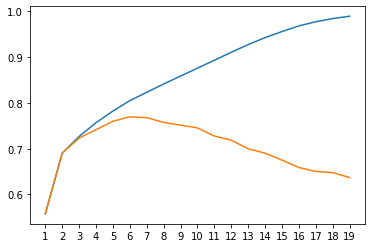

In [53]:
train_score = gcv5.cv_results_['mean_train_score']
test_score = gcv5.cv_results_['mean_test_score']

plt.plot(train_score)
plt.plot(test_score)
plt.xticks(range(0, len(gcv5.param_grid['max_depth'])), list(gcv5.param_grid['max_depth']))

In [54]:
pred_list['dt'] = gcv5.predict_proba(X)[:,1]

In [55]:
y_pred5 = gcv5.predict_proba(X_test)[:,1]
y_pred5

array([0.19736842, 0.00507072, 0.04099787, ..., 0.04099787, 0.04099787,
       0.04099787])

In [56]:
roc_auc_score(y_test, y_pred5)
# 0.765314891610439

0.7633673201663813

In [57]:
pred_list_test['dt'] = y_pred5

## Stacking(Random Forest)

In [58]:
# sel_col = ['lgb', 'xgb', 'logistic', 'rf', 'dt']

sel_col = ['lgb', 'xgb', 'rf']

In [59]:
pred_df = pd.DataFrame(pred_list)
pred_df[sel_col]

,lgb,xgb,rf
0,0.004709,0.003563,0.001603
1,0.021986,0.010938,0.012014
2,0.316792,0.341647,0.335118
3,0.052027,0.064344,0.039605
4,0.005305,0.003110,0.001172
...,...,...,...
18965,0.062995,0.059195,0.037418
18966,0.109896,0.100834,0.015425
18967,0.083966,0.090500,0.022662
18968,0.033558,0.029297,0.006774


In [60]:
pred_df_test = pd.DataFrame(pred_list_test)
pred_df_test[sel_col]

,lgb,xgb,rf
0,0.079738,0.059853,0.066140
1,0.011654,0.003545,0.004619
2,0.054321,0.048347,0.130433
3,0.139192,0.138751,0.096329
4,0.013345,0.011991,0.010580
...,...,...,...
8125,0.062763,0.067413,0.065269
8126,0.056340,0.086656,0.165269
8127,0.025366,0.014020,0.028261
8128,0.050834,0.047149,0.075755


### RandomForest

In [61]:
parameters = {
    'max_depth': list(range(1, 20)),
    'max_features': [1, 2, 3, 4, 5, 7, 10],
}

In [62]:
gcv_st1 = GridSearchCV(rf, parameters, cv=5, scoring="roc_auc", n_jobs=-1, return_train_score=True)
gcv_st1.fit(pred_df[sel_col], y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [63]:
y_pred_st1 = gcv_st1.predict_proba(pred_df_test[sel_col])[:,1]
y_pred_st1

array([1.78017843e-03, 1.74177343e-05, 3.81234567e-01, ...,
       2.88885713e-05, 2.37973559e-03, 2.57570484e-02])

In [64]:
roc_auc_score(y_test, y_pred_st1)

0.8078053905366095

### LightGBM

In [65]:
parameters = {
    'max_depth': list(range(1, 20)),
    'feature_fraction': [1, 2, 3, 4, 5, 7, 10],
}

In [66]:
gcv_st2 = GridSearchCV(lgb, parameters, cv=5, scoring="roc_auc", n_jobs=-1, return_train_score=True)
gcv_st2.fit(pred_df[sel_col], y)

[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'feature_fraction': [1, 2, 3, 4, 5, 7, 10],
                         'm

In [67]:
y_pred_st2 = gcv_st2.predict_proba(pred_df_test[sel_col])[:,1]
y_pred_st2

array([4.28010900e-03, 6.08475148e-05, 3.17902500e-01, ...,
       3.61680962e-05, 6.68147367e-03, 2.49971881e-02])

In [68]:
roc_auc_score(y_test, y_pred_st2)

0.8039005967614766

### XGBoost

In [69]:
parameters = {
    'max_depth': list(range(1, 20)),
    'colsample_bytree': [1, 2, 3, 4, 5, 7, 10],
}

In [ ]:
gcv_st3 = GridSearchCV(xgb, parameters, cv=5, scoring="roc_auc", n_jobs=-1, return_train_score=True)
gcv_st3.fit(pred_df[sel_col], y)

In [ ]:
y_pred_st3 = gcv_st3.predict_proba(pred_df_test[sel_col])[:,1]
y_pred_st3

In [ ]:
roc_auc_score(y_test, y_pred_st3)

# Test Data Predict